In [2]:
import os
import pandas as pd
import numpy as np
import time
from tqdm import notebook as nb
import requests
from bs4 import BeautifulSoup
import re
import os
import pickle
import glob

import matplotlib.pyplot as plt
from collections import Counter
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve


In [3]:
race_place = {"桐生":1,"戸田":2,"江戸川":3,"平和島":4,"多摩川":5,"浜名湖":6,"蒲郡":7,"常滑":8,"津":9,"三国":10,"びわこ":11,"住之江":12,
              "尼崎":13,"鳴門":14,"丸亀":15,"児島":16,"宮島":17,"徳山":18,"下関":19,"若松":20,"芦屋":21,"福岡":22,"唐津":23,"大村":24}

In [15]:
file_list = sorted(glob.glob("/mounted/tobe/dataset/dataset1[5-8].csv"))
print(file_list)
dataset = pd.read_csv("/mounted/tobe/dataset/dataset14.csv",index_col=0)
for f in file_list:
    tmp = pd.read_csv(f,index_col=0)
    dataset = pd.concat([dataset,tmp],ignore_index=True, axis=0)
dataset

['/mounted/tobe/dataset/dataset15.csv', '/mounted/tobe/dataset/dataset16.csv', '/mounted/tobe/dataset/dataset17.csv', '/mounted/tobe/dataset/dataset18.csv']


,レースID,123,1号艇1着率,1号艇2着率,1号艇3着率,2号艇1着率,2号艇2着率,2号艇3着率,3号艇1着率,3号艇2着率,3号艇3着率,4号艇1着率,4号艇2着率,4号艇3着率,5号艇1着率,5号艇2着率,5号艇3着率,6号艇1着率,6号艇2着率,6号艇3着率
0,201401012402,False,0.471338,0.216561,0.063694,0.125000,0.135417,0.218750,0.000000,0.000000,0.454545,0.074468,0.106383,0.244681,0.020000,0.090000,0.090000,0.000000,0.064516,0.129032
1,201401012404,False,0.465116,0.209302,0.081395,0.258741,0.265734,0.167832,0.107843,0.215686,0.176471,0.013158,0.105263,0.263158,0.109244,0.226891,0.277311,0.041237,0.072165,0.216495
2,201401012405,False,0.550633,0.177215,0.069620,0.236842,0.192982,0.105263,0.042373,0.127119,0.169492,0.086957,0.130435,0.217391,0.067227,0.126050,0.210084,0.000000,0.036145,0.024096
3,201401012407,False,0.439394,0.196970,0.136364,0.095238,0.083333,0.178571,0.096154,0.134615,0.211538,0.105263,0.210526,0.126316,0.000000,0.023529,0.070588,0.000000,0.000000,0.018868
4,201401012408,False,0.182927,0.268293,0.134146,0.090000,0.160000,0.140000,0.183099,0.204225,0.161972,0.100000,0.180000,0.220000,0.108333,0.166667,0.275000,0.000000,0.000000,0.021277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234717,201812310107,False,0.503650,0.262774,0.109489,0.000000,0.037037,0.185185,0.045455,0.163636,0.209091,0.157895,0.233083,0.263158,0.023810,0.083333,0.095238,0.090000,0.060000,0.260000
234718,201812310109,False,0.581818,0.172727,0.109091,0.130435,0.231884,0.246377,0.027523,0.110092,0.183486,0.078125,0.171875,0.109375,0.055046,0.110092,0.183486,0.121495,0.093458,0.130841
234719,201812310110,True,0.585034,0.210884,0.088435,0.111111,0.272727,0.151515,0.224299,0.261682,0.308411,0.084906,0.198113,0.207547,0.010309,0.134021,0.175258,0.009615,0.057692,0.153846
234720,201812310111,False,0.495935,0.268293,0.121951,0.241135,0.283688,0.177305,0.268657,0.194030,0.253731,0.137615,0.275229,0.174312,0.051282,0.179487,0.102564,0.000000,0.012821,0.064103


In [5]:
def mean_norm(df_input):
    df_input[df_input.columns[df_input.columns != "レースID"].values] = df_input[df_input.columns[df_input.columns != "レースID"].values].apply(lambda x:( (x - x.mean()) / x.std()), axis=0)
    return df_input

In [21]:

race_features = dataset[['レースID','1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
race_label = dataset['123'] * 1
race_features = mean_norm(race_features)
data_train,data_test,label_train,label_test = train_test_split(race_features,race_label,test_size =0.01, random_state=1)
features_train = data_train[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
features_test = data_test[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
features_train
# race_features.columns[race_features.columns != "レースID"]

/tmp/ipykernel_949441/549638298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[df_input.columns[df_input.columns != "レースID"].values] = df_input[df_input.columns[df_input.columns != "レースID"].values].apply(lambda x:( (x - x.mean()) / x.std()), axis=0)


,1号艇1着率,1号艇2着率,1号艇3着率,2号艇1着率,2号艇2着率,2号艇3着率,3号艇1着率,3号艇2着率,3号艇3着率,4号艇1着率,4号艇2着率,4号艇3着率,5号艇1着率,5号艇2着率,5号艇3着率,6号艇1着率,6号艇2着率,6号艇3着率
89492,-0.926290,0.626200,0.422749,-1.334123,-0.793310,0.579358,0.281566,-0.822591,-0.479963,0.524010,1.517672,-0.880512,3.276787,2.310228,0.287269,-0.990793,-1.548880,-1.691773
26382,-0.923276,-0.486361,0.318328,-0.558814,-0.198043,0.211469,-1.024588,-0.531947,-1.032224,-0.925998,-2.009821,-0.817748,-0.638360,-1.030730,-1.717061,-0.990793,-0.695656,-0.864656
56003,-0.103701,0.938164,-0.634412,0.979890,1.404358,-0.430128,-0.015436,0.169851,-0.356811,1.333611,1.036974,1.142059,-0.566150,-0.281447,0.591748,0.303349,-0.621603,-0.607157
183745,1.206808,-0.469919,-0.987543,-0.901528,-1.444555,-0.558856,-1.623805,-0.669620,-1.323718,-0.911769,-0.743803,-0.460073,1.113823,1.521390,0.569804,0.297273,-1.087418,-0.241406
180185,-0.255017,0.919692,0.185427,0.431298,0.620450,0.690653,-0.567749,0.649378,1.427754,-1.125203,-0.013981,0.306372,0.406700,0.303244,-0.012651,0.477484,0.855802,1.415606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229119,-0.408480,0.266900,1.144814,-0.374082,-0.382864,1.283026,1.329708,1.401464,-0.309826,0.268533,1.684216,0.046702,0.098554,-0.196343,-0.159019,-0.609740,-0.183722,-1.112791
5192,-0.110622,0.492863,0.895800,0.188642,0.092390,-2.172483,-0.026190,-0.032750,0.512541,-0.939719,-0.571189,0.041766,-1.358136,-1.949493,-1.102799,0.693862,0.175530,1.237962
208780,1.526671,-1.250143,-1.027551,1.017519,1.206668,-1.439355,-1.512933,-0.982946,0.569060,-0.390041,-0.224984,0.320565,0.495833,0.890321,0.456790,-0.459092,-0.405957,0.510666
229611,0.246969,-0.313942,0.049815,2.291892,-0.117004,-0.294192,-0.832344,-2.544094,-3.227916,-0.177337,0.062782,-0.027720,0.152505,1.232150,1.549255,-0.755091,-0.704452,0.350438


In [32]:
model = LogisticRegression(penalty='l2',          # 正則化項(L1正則化 or L2正則化が選択可能)
                           dual=False,            # Dual or primal
                           tol=0.0001,            # 計算を停止するための基準値
                           C=1.0,                 # 正則化の強さ
                           fit_intercept=True,    # バイアス項の計算要否
                           intercept_scaling=1,   # solver=‘liblinear’の際に有効なスケーリング基準値
                           class_weight=None,     # クラスに付与された重み
                           random_state=None,     # 乱数シード
                           solver='lbfgs',        # ハイパーパラメータ探索アルゴリズム
                           max_iter=1000,          # 最大イテレーション数
                           multi_class='auto',    # クラスラベルの分類問題（2値問題の場合'auto'を指定）
                           verbose=0,             # liblinearおよびlbfgsがsolverに指定されている場合、冗長性のためにverboseを任意の正の数に設定
                           warm_start=False,      # Trueの場合、モデル学習の初期化に前の呼出情報を利用
                           n_jobs=None,           # 学習時に並列して動かすスレッドの数
                           l1_ratio=None          # L1/L2正則化比率(penaltyでElastic Netを指定した場合のみ)
                          )

model.fit(features_train,label_train)

LogisticRegression(max_iter=1000)

In [33]:
df_model = pd.DataFrame(index=['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率'])
df_model["偏回帰係数"] = model.coef_[0]
df_model

,偏回帰係数
1号艇1着率,0.577020
1号艇2着率,0.068927
1号艇3着率,0.025376
2号艇1着率,0.244160
2号艇2着率,0.174237
2号艇3着率,0.075834
3号艇1着率,0.026535
3号艇2着率,0.096796
3号艇3着率,0.093387
4号艇1着率,-0.161455


In [199]:
pred_proba = model.predict_proba(features_test)
label_test = label_test.reset_index(drop=True)
label_train = label_train.reset_index(drop=True)
df_proba = pd.DataFrame()
df_proba["123"] = pred_proba[:,1]
df_proba["正解"] = label_test
# df_proba
data_test = data_test.reset_index(drop=True)
data_train = data_train.reset_index(drop=True)
df_proba["レースID"] = data_test["レースID"]
# df_proba["オッズ"] = ""
# df_proba["日付"] = dataset_test["日付"].astype(int).astype(str)
# df_proba[(df_proba["123"]>0.11)&(df_proba["正解"]==1)]
df_proba[(df_proba["123"] > 0.2)]


,123,正解,レースID
186,0.209362,0,201409071901
202,0.209654,0,202209141511
306,0.216917,0,201605292302
716,0.280247,1,201810271606
743,0.200488,0,201408091606
...,...,...,...
84566,0.200844,0,201808042302
84776,0.304857,0,201907011804
84945,0.254999,0,202206170109
85205,0.268410,0,202012021305


In [202]:
y_pred = ((pred_proba[:, 1] > 0.2)&(pred_proba[:, 1] < 0.25)).astype(int)
print('Confusion matrix:\n{}'.format(confusion_matrix(label_test,  y_pred)))

Confusion matrix:
[[79041   491]
 [ 5668   126]]


In [39]:

test_data = pd.read_csv("/mounted/tobe/dataset/dataset2308.csv",index_col=0)
for i in range(2309,2312):
    tmp = pd.read_csv("/mounted/tobe/dataset/dataset"+str(i)+".csv",index_col=0)
    test_data = pd.concat([test_data,tmp],ignore_index=True, axis=0)

test_data = test_data.dropna(how="any").reset_index(drop=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15608 entries, 0 to 15607
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   レースID   15608 non-null  int64  
 1   123     15608 non-null  bool   
 2   1号艇1着率  15608 non-null  float64
 3   1号艇2着率  15608 non-null  float64
 4   1号艇3着率  15608 non-null  float64
 5   2号艇1着率  15608 non-null  float64
 6   2号艇2着率  15608 non-null  float64
 7   2号艇3着率  15608 non-null  float64
 8   3号艇1着率  15608 non-null  float64
 9   3号艇2着率  15608 non-null  float64
 10  3号艇3着率  15608 non-null  float64
 11  4号艇1着率  15608 non-null  float64
 12  4号艇2着率  15608 non-null  float64
 13  4号艇3着率  15608 non-null  float64
 14  5号艇1着率  15608 non-null  float64
 15  5号艇2着率  15608 non-null  float64
 16  5号艇3着率  15608 non-null  float64
 17  6号艇1着率  15608 non-null  float64
 18  6号艇2着率  15608 non-null  float64
 19  6号艇3着率  15608 non-null  float64
dtypes: bool(1), float64(18), int64(1)
memory usage: 2.3 MB


In [40]:

test_features = test_data[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
# tmp = dataset[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
test_label = test_data["123"]
# test_features = pd.concat([tmp,test_features], ignore_index=True, axis=0)
test_features = mean_norm(test_features)
# test_features = test_features[len(tmp):].reset_index(drop=True)
pred_proba = model.predict_proba(test_features)
df_proba = pd.DataFrame()
df_proba["123"] = pred_proba[:,1]
df_proba["正解"] = test_label
df_proba.info()
df_proba["レースID"] = test_data["レースID"]
# df_proba[(df_proba["123"] > 0.2)]
df_proba.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15608 entries, 0 to 15607
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   123     15608 non-null  float64
 1   正解      15608 non-null  bool   
dtypes: bool(1), float64(1)
memory usage: 137.3 KB


/tmp/ipykernel_949441/549638298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[df_input.columns[df_input.columns != "レースID"].values] = df_input[df_input.columns[df_input.columns != "レースID"].values].apply(lambda x:( (x - x.mean()) / x.std()), axis=0)


123      float64
正解          bool
レースID      int64
dtype: object

In [218]:
y_pred = ((pred_proba[:, 1] > 0.2)).astype(int)
print('Confusion matrix:\n{}'.format(confusion_matrix(test_label,  y_pred)))

Confusion matrix:
[[14353   105]
 [ 1115    27]]


In [41]:
df_proba = df_proba.astype({"レースID":str})

In [48]:
count = 0
odd = 0
pre_date = ""
od = pd.DataFrame(columns=['オッズ', 'レースID'])
file_list = sorted(glob.glob("/mounted/tobe/odds/3rentan/csv/t*.csv"))
df_proba["オッズ"] = 0
for f in file_list:
    odds = pd.read_csv(f)
    print(f)
    odds["レースID"] = [str(v["日付"]) + str(race_place[v["開催地"]]).zfill(2) + str(v["ラウンド名"]).zfill(2) for i, v in odds.iterrows()]
    for index,row in odds.iterrows():
        df_proba.loc[df_proba["レースID"]==row["レースID"],"オッズ"] = row["123"]
        # print(df_proba.loc[df_proba["レースID"]==row["レースID"],"オッズ"])
        
df_proba[(df_proba["123"] > 0.2) & (df_proba["正解"]==1)]

/mounted/data/odds/3rentan/csv/t20170701.csv
/mounted/data/odds/3rentan/csv/t20170702.csv
/mounted/data/odds/3rentan/csv/t20170703.csv
/mounted/data/odds/3rentan/csv/t20170704.csv
/mounted/data/odds/3rentan/csv/t20170705.csv
/mounted/data/odds/3rentan/csv/t20170706.csv
/mounted/data/odds/3rentan/csv/t20170707.csv
/mounted/data/odds/3rentan/csv/t20170708.csv
/mounted/data/odds/3rentan/csv/t20170709.csv
/mounted/data/odds/3rentan/csv/t20170710.csv


KeyboardInterrupt: 

In [44]:
df_proba = df_proba.astype({"オッズ":float})
# df_proba.dtypes
print(df_proba[(df_proba["123"] > 0.1)].describe())
print(df_proba[(df_proba["123"] > 0.2)&(df_proba["正解"]==1)].describe())


               123          オッズ
count  2316.000000  2316.000000
mean      0.132518     7.771675
std       0.031222     4.559744
min       0.100012     0.000000
25%       0.110186     5.100000
50%       0.122893     6.700000
75%       0.145465     9.200000
max       0.316350    43.800000
             123        オッズ
count  22.000000  22.000000
mean    0.228324   5.059091
std     0.027323   2.811483
min     0.200156   2.700000
25%     0.208672   3.425000
50%     0.220536   4.100000
75%     0.241603   5.725000
max     0.316341  14.500000


In [ ]:
pkl = pd.DataFrame()
pkl["レースID"] = df_proba[(df_proba["123"]*df_proba["オッズ"] > 1) & (df_proba["123"] > 0.2)]["レースID"]
pkl["1着"] = 1
pkl["2着"] = 2
pkl["3着"] = 3
pkl["ベット額"] = 10000
pkl = pkl.astype({"レースID":str})
pkl.to_pickle("M1.pkl")
pkl

,レースID,1着,2着,3着,ベット額
623,202308051804,1,2,3,100
945,202308072104,1,2,3,100
958,202308071905,1,2,3,100
994,202308071412,1,2,3,100
997,202308071003,1,2,3,100
1261,202308102008,1,2,3,100
1402,202308112005,1,2,3,100
1503,202308110610,1,2,3,100
1777,202308132008,1,2,3,100
1982,202308142203,1,2,3,100


[0.00188875 0.00199623 0.00229661 ... 0.35973777 0.36265455 0.39817905]
[0.00188875 0.00199623 0.00229661 ... 0.35973777 0.36265455 0.39817905]


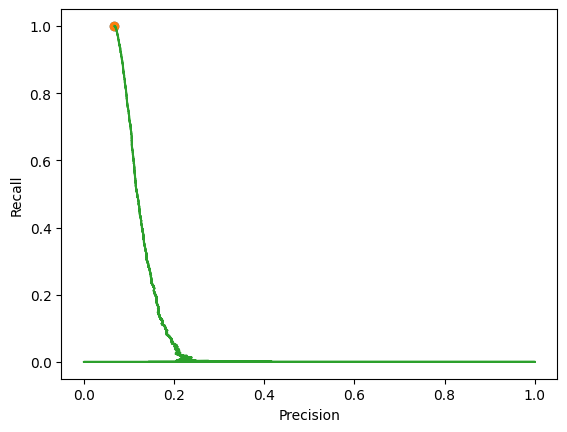

In [14]:
precision, recall, threshold = precision_recall_curve(label_test, model.predict_proba(features_test)[:, 1])

# 0から1まで0.05刻みで○をプロット
for i in range(2):
    close_point = np.argmin(np.abs(threshold))
    plt.plot(precision[close_point], recall[close_point], 'o')
    print(threshold)

# 適合率-再現率曲線
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

plt.show()

In [30]:

test_data2 = pd.read_csv("/mounted/tobe/dataset/dataset19.csv",index_col=0)
for i in range(20,23):
    tmp = pd.read_csv("/mounted/tobe/dataset/dataset"+str(i)+".csv",index_col=0)
    test_data2 = pd.concat([test_data2,tmp],ignore_index=True, axis=0)
# print(test_data2.info())
test_data2 = test_data2.dropna(how="any").reset_index(drop=True)
print(test_data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191904 entries, 0 to 191903
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   レースID   191904 non-null  int64  
 1   123     191904 non-null  bool   
 2   1号艇1着率  191904 non-null  float64
 3   1号艇2着率  191904 non-null  float64
 4   1号艇3着率  191904 non-null  float64
 5   2号艇1着率  191904 non-null  float64
 6   2号艇2着率  191904 non-null  float64
 7   2号艇3着率  191904 non-null  float64
 8   3号艇1着率  191904 non-null  float64
 9   3号艇2着率  191904 non-null  float64
 10  3号艇3着率  191904 non-null  float64
 11  4号艇1着率  191904 non-null  float64
 12  4号艇2着率  191904 non-null  float64
 13  4号艇3着率  191904 non-null  float64
 14  5号艇1着率  191904 non-null  float64
 15  5号艇2着率  191904 non-null  float64
 16  5号艇3着率  191904 non-null  float64
 17  6号艇1着率  191904 non-null  float64
 18  6号艇2着率  191904 non-null  float64
 19  6号艇3着率  191904 non-null  float64
dtypes: bool(1), float64(18), int64(1)
memory usage: 

In [49]:

test_features2 = test_data2[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
# tmp = dataset[['1号艇1着率','1号艇2着率','1号艇3着率','2号艇1着率','2号艇2着率','2号艇3着率','3号艇1着率','3号艇2着率','3号艇3着率','4号艇1着率','4号艇2着率','4号艇3着率','5号艇1着率','5号艇2着率','5号艇3着率','6号艇1着率','6号艇2着率','6号艇3着率']]
test_label2 = test_data2["123"]
# test_features = pd.concat([tmp,test_features], ignore_index=True, axis=0)
test_features2 = mean_norm(test_features2)
# test_features = test_features[len(tmp):].reset_index(drop=True)
pred_proba2 = model.predict_proba(test_features2)
df_proba2 = pd.DataFrame()
df_proba2["123"] = pred_proba2[:,1]
df_proba2["正解"] = test_label2
df_proba2.info()
df_proba2["レースID"] = test_data2["レースID"]
# df_proba[(df_proba["123"] > 0.2)]
df_proba2.dtypes
df_proba2 = df_proba2.astype({"レースID":str})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191904 entries, 0 to 191903
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   123     191904 non-null  float64
 1   正解      191904 non-null  bool   
dtypes: bool(1), float64(1)
memory usage: 1.6 MB


/tmp/ipykernel_949441/549638298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[df_input.columns[df_input.columns != "レースID"].values] = df_input[df_input.columns[df_input.columns != "レースID"].values].apply(lambda x:( (x - x.mean()) / x.std()), axis=0)


In [52]:
count = 0
odd = 0
pre_date = ""
od = pd.DataFrame(columns=['オッズ', 'レースID'])
file_list = sorted(glob.glob("/mounted/data/odds/3rentan/csv/t20[1-2][0-28-9]*.csv"))
df_proba2["オッズ"] = 0
for f in file_list:
    odds = pd.read_csv(f)
    print(f)
    odds["レースID"] = [str(v["日付"]) + str(race_place[v["開催地"]]).zfill(2) + str(v["ラウンド名"]).zfill(2) for i, v in odds.iterrows()]
    for index,row in odds.iterrows():
        df_proba2.loc[(df_proba2["レースID"]==row["レースID"]),"オッズ"] = row["123"]
        # print(df_proba.loc[df_proba["レースID"]==row["レースID"],"オッズ"])
        
df_proba2[(df_proba2["123"] > 0.2) & (df_proba2["正解"]==1)]

/mounted/data/odds/3rentan/csv/t20180101.csv
/mounted/data/odds/3rentan/csv/t20180102.csv
/mounted/data/odds/3rentan/csv/t20180103.csv
/mounted/data/odds/3rentan/csv/t20180104.csv
/mounted/data/odds/3rentan/csv/t20180105.csv
/mounted/data/odds/3rentan/csv/t20180106.csv
/mounted/data/odds/3rentan/csv/t20180107.csv
/mounted/data/odds/3rentan/csv/t20180108.csv
/mounted/data/odds/3rentan/csv/t20180109.csv
/mounted/data/odds/3rentan/csv/t20180110.csv
/mounted/data/odds/3rentan/csv/t20180111.csv
/mounted/data/odds/3rentan/csv/t20180112.csv
/mounted/data/odds/3rentan/csv/t20180113.csv
/mounted/data/odds/3rentan/csv/t20180114.csv
/mounted/data/odds/3rentan/csv/t20180115.csv
/mounted/data/odds/3rentan/csv/t20180116.csv
/mounted/data/odds/3rentan/csv/t20180117.csv
/mounted/data/odds/3rentan/csv/t20180118.csv
/mounted/data/odds/3rentan/csv/t20180119.csv
/mounted/data/odds/3rentan/csv/t20180120.csv
/mounted/data/odds/3rentan/csv/t20180121.csv
/mounted/data/odds/3rentan/csv/t20180122.csv
/mounted/d

,123,正解,レースID,オッズ
926,0.242217,True,201901062008,5.2
1631,0.215931,True,201901112008,4.1
1718,0.239094,True,201901110304,6.6
2589,0.235067,True,201901172008,3.8
3083,0.274557,True,201901200812,3.2
...,...,...,...,...
189840,0.229913,True,202212160510,4.0
189995,0.208833,True,202212182105,16.7
190955,0.226561,True,202212262410,3.0
191248,0.211203,True,202212282211,3.4


In [69]:
df_proba2 = df_proba2.astype({"オッズ":float})
df_proba2[(df_proba2["123"] > 0.2)&(df_proba2["123"] * df_proba2["オッズ"] > 1.2)].info()
df_proba2[(df_proba2["123"] > 0.2)&(df_proba2["123"] * df_proba2["オッズ"] > 1.2)]["オッズ"].sum()


<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 926 to 191264
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   123     374 non-null    float64
 1   正解      374 non-null    bool   
 2   レースID   374 non-null    object 
 3   オッズ     374 non-null    float64
dtypes: bool(1), float64(2), object(1)
memory usage: 12.1+ KB


2739.4